# **Joining traffic data from the Stanford Policing data set with weather data in Rhode Island to determine how weather affects traffic violations.**

First, we will import some basic funcitons for exploratory data analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Next, we will import the data sets.  We will work with the police traffic data set from Rhode Island first and get to the weather data for Rhode Island later.

In [2]:
ri = pd.read_csv('/Users/brian/Desktop/police.csv')

weather = pd.read_csv('/Users/brian/Desktop/weather.csv')

In [3]:
print(ri.head())

    stop_date stop_time  county_name driver_gender  driver_age_raw  \
0  2005-01-02     01:55          NaN             M          1985.0   
1  2005-01-18     08:15          NaN             M          1965.0   
2  2005-01-23     23:15          NaN             M          1972.0   
3  2005-02-20     17:15          NaN             M          1986.0   
4  2005-03-14     10:00          NaN             F          1984.0   

   driver_age driver_race     violation_raw violation  search_conducted  \
0        20.0       White          Speeding  Speeding             False   
1        40.0       White          Speeding  Speeding             False   
2        33.0       White          Speeding  Speeding             False   
3        19.0       White  Call for Service     Other             False   
4        21.0       White          Speeding  Speeding             False   

  search_type   stop_outcome is_arrested stop_duration  drugs_related_stop  
0         NaN       Citation       False      0-15 

In [4]:
ri.isnull().sum()

stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5335
driver_age_raw         5327
driver_age             5621
driver_race            5333
violation_raw          5333
violation              5333
search_conducted          0
search_type           88545
stop_outcome           5333
is_arrested            5333
stop_duration          5333
drugs_related_stop        0
dtype: int64

We have a large number of null values, especially in county name and search type.  For now, we will drop the county name and revisit it if we want county-specific data.

In [5]:
ri.drop(['county_name'], axis='columns', inplace=True)

In [6]:
ri.isnull().sum()

stop_date                 0
stop_time                 0
driver_gender          5335
driver_age_raw         5327
driver_age             5621
driver_race            5333
violation_raw          5333
violation              5333
search_conducted          0
search_type           88545
stop_outcome           5333
is_arrested            5333
stop_duration          5333
drugs_related_stop        0
dtype: int64

In [7]:
ri.dropna(subset=['driver_gender'], inplace=True)

We dropped nulls from the driver gender column since the percentage was small and we want to understand effects of gender on traffic violations.  This helped out a great deal with exception of the search_type column. Let's start with the hypothesis that more men have speeding and other moving violations than women and test that out on the data. Also, let's assume that women get searched more since they are at risk of male predators, even if they are cops.

In [8]:
ri.isnull().sum()

stop_date                 0
stop_time                 0
driver_gender             0
driver_age_raw            1
driver_age              293
driver_race               0
violation_raw             0
violation                 0
search_conducted          0
search_type           83210
stop_outcome              0
is_arrested               0
stop_duration             0
drugs_related_stop        0
dtype: int64

In [9]:
ri.shape

(86406, 14)

Now, we will drop 'driver_age_raw' and 'driver_age' to provide a data set free of missing values except for the search type, which we will ignore for the time being.

In [10]:
ri.dropna(subset=['driver_age_raw', 'driver_age'], inplace=True)

In [11]:
ri.shape

(86113, 14)

Let's set the is_arrested column as a boolean data type.

In [12]:
ri['is_arrested'] = ri.is_arrested.astype('bool')

Now, we will concatenate date fields and produce a datetime object for the stop_datetime column.

In [13]:
# Concatenate 'stop_date' and 'stop_time' (separated by a space)
combined = ri.stop_date.str.cat(ri.stop_time, sep = ' ')

# Converting 'combined' to datetime format
ri['stop_datetime'] = pd.to_datetime(combined)

In [14]:
# Examine the data types of the DataFrame
ri.dtypes

stop_date                     object
stop_time                     object
driver_gender                 object
driver_age_raw               float64
driver_age                   float64
driver_race                   object
violation_raw                 object
violation                     object
search_conducted                bool
search_type                   object
stop_outcome                  object
is_arrested                     bool
stop_duration                 object
drugs_related_stop              bool
stop_datetime         datetime64[ns]
dtype: object

In [15]:
# Setting 'stop_datetime' as the index
ri.set_index('stop_datetime', inplace=True)

In [16]:
# Counting the unique values in 'violation'
ri.violation.value_counts()

Speeding               48359
Moving violation       16164
Equipment              11007
Other                   4204
Registration/plates     3427
Seat belt               2952
Name: violation, dtype: int64

In [17]:
# Expressing the counts as proportions
ri.violation.value_counts(normalize = True)

Speeding               0.561576
Moving violation       0.187707
Equipment              0.127820
Other                  0.048820
Registration/plates    0.039797
Seat belt              0.034281
Name: violation, dtype: float64

Looks like speeding accounts for more than 50% of the traffic stops.

In [18]:
# Creating a DataFrame of female drivers
female = ri[ri.driver_gender == 'F']

# Creating a DataFrame of male drivers
male = ri[ri.driver_gender == 'M']

# Computing the violations by female drivers 
print(female.violation.value_counts(normalize = True))
print()

# Computing the violations by male drivers 
print(male.violation.value_counts(normalize = True))

Speeding               0.658583
Moving violation       0.136166
Equipment              0.105864
Registration/plates    0.043130
Other                  0.029194
Seat belt              0.027063
Name: violation, dtype: float64

Speeding               0.525244
Moving violation       0.207010
Equipment              0.136044
Other                  0.056170
Registration/plates    0.038548
Seat belt              0.036984
Name: violation, dtype: float64


Interesting, it appears as if women speed more but this could be misleading as maybe they do not have as many other moving violations as men.

In [19]:
# Creating a DataFrame of female drivers stopped for speeding
female_and_speeding = ri[(ri.driver_gender == 'F') & (ri.violation == 'Speeding')]


# Creating a DataFrame of male drivers stopped for speeding
male_and_speeding = ri[(ri.driver_gender == 'M') & (ri.violation == 'Speeding')]


# Computing the stop outcomes for female drivers (as proportions)
print(female_and_speeding.stop_outcome.value_counts(normalize = True))
print()

# Computing the stop outcomes for male drivers (as proportions)
print(male_and_speeding.stop_outcome.value_counts(normalize = True))

Citation            0.953407
Warning             0.039086
Arrest Driver       0.005371
Arrest Passenger    0.000841
N/D                 0.000841
No Action           0.000453
Name: stop_outcome, dtype: float64

Citation            0.947244
Warning             0.034188
Arrest Driver       0.015195
Arrest Passenger    0.001246
No Action           0.001064
N/D                 0.001064
Name: stop_outcome, dtype: float64


Interesting! The numbers are similar for males and females: about 95% of stops for speeding result in a ticket. Thus, the data fails to show that gender has an impact on who gets a ticket for speeding.

In [20]:
# Calculating the search rate by counting the values
ri.search_conducted.value_counts(normalize = True)

False    0.962921
True     0.037079
Name: search_conducted, dtype: float64

In [21]:
ri.groupby('driver_gender').search_conducted.mean()

driver_gender
F    0.020073
M    0.043448
Name: search_conducted, dtype: float64

In [22]:
ri.groupby(['violation', 'driver_gender']).search_conducted.mean()

violation            driver_gender
Equipment            F                0.042673
                     M                0.070163
Moving violation     F                0.036307
                     M                0.060066
Other                F                0.056934
                     M                0.048309
Registration/plates  F                0.066206
                     M                0.110145
Seat belt            F                0.012598
                     M                0.037980
Speeding             F                0.008736
                     M                0.024950
Name: search_conducted, dtype: float64

For all types of violations except for "Other", the search rate is higher for males than for females, disproving our hypothesis. Let's finally take a look at search type.

In [23]:
# Counting the 'search_type' values
print(ri.search_type.value_counts())

# Checking if 'search_type' contains the string 'Protective Frisk'
ri['frisk'] = ri.search_type.str.contains('Protective Frisk', na=False)

# Checking the data type of 'frisk'
print(ri.frisk.dtype)

# Taking the sum of 'frisk'
print(ri.frisk.sum())

Incident to Arrest                                          1219
Probable Cause                                               890
Inventory                                                    220
Reasonable Suspicion                                         197
Protective Frisk                                             160
Incident to Arrest,Inventory                                 129
Incident to Arrest,Probable Cause                            106
Probable Cause,Reasonable Suspicion                           75
Incident to Arrest,Inventory,Probable Cause                   34
Probable Cause,Protective Frisk                               33
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      22
Incident to Arrest,Reasonable Suspicion                       13
Inventory,Protective Frisk                                    11
Incident to Arrest,Inventory,Protective Frisk                 11
Protective Frisk,Reasonab

272 searches included a protective frisk.  The majority of searches occured because on an incident to arrest or because the officer had probable cause.  

In [24]:
# Creating a DataFrame of stops in which a search was conducted
searched = ri[ri.search_conducted == True]

# Calculating the overall frisk rate by taking the mean of 'frisk'
print(searched.frisk.mean())

# Calculating the frisk rate for each gender
print(searched.groupby('driver_gender').frisk.mean())

0.08518634512997181
driver_gender
F    0.061571
M    0.089273
Name: frisk, dtype: float64


More men were frisked and involved traffic stops where a search was conducted as the percentage for women was much lower than the average disproving our hypothesis again.

In [25]:
# Counting the 'search_type' values
print(ri.search_conducted.value_counts())

# Checking if 'search_type' contains the string 'Protective Frisk'
ri['inventory'] = ri.search_type.str.contains('Inventory', na=False)

# Checking the data type of 'frisk'
print(ri.inventory.dtype)

# Taking the sum of 'frisk'
print(ri.inventory.sum())

searched = ri[ri['search_conducted'] == True]

searched.inventory.mean()

False    82920
True      3193
Name: search_conducted, dtype: int64
bool
439


0.13748825555903538

About 13.7% of the stops included taking inventory.

In [26]:
print(ri.is_arrested.mean())
print()
print(ri.groupby(ri.index.hour).is_arrested.mean())
hourly_arrest_rate = ri.groupby(ri.index.hour).is_arrested.mean()

0.033966996852972255

stop_datetime
0     0.047334
1     0.061581
2     0.062983
3     0.053421
4     0.074074
5     0.031915
6     0.014115
7     0.013569
8     0.020579
9     0.024670
10    0.025362
11    0.027149
12    0.033116
13    0.030158
14    0.032839
15    0.032399
16    0.030919
17    0.032448
18    0.044096
19    0.031173
20    0.041113
21    0.053954
22    0.043492
23    0.042898
Name: is_arrested, dtype: float64


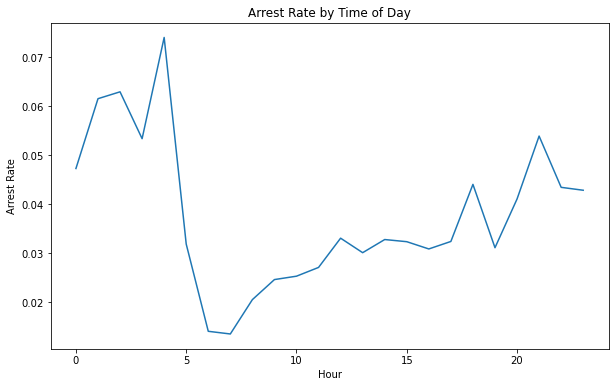

In [27]:
fig = plt.figure(figsize=(10,6))
hourly_arrest_rate.plot()
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')
plt.show()

This is quite obvious as the arrest rate is at its highest in the early morning hours and decreases around sunrise.  The arrest rate elevates consitently into the evening.

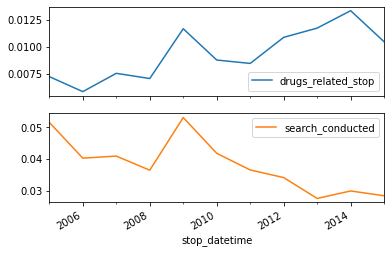

In [28]:
# Saving the annual rate of drug-related stops
annual_drug_rate = ri.drugs_related_stop.resample('A').mean()

# Calculating and saving the annual search rate
annual_search_rate = ri.search_conducted.resample('A').mean()

annual = pd.concat([annual_drug_rate, annual_search_rate], axis=1)

# Creating line plots of 'annual_drug_rate'
annual.plot(subplots = True)
plt.show()

Drug related stops are on the rise as searches being conducted is declining.

In [29]:
# Printing the unique values in 'stop_duration'
print(ri.stop_duration.unique())

# Creating a dictionary that maps strings to integers
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45}

# Converting the 'stop_duration' strings to integers using the 'mapping'
ri['stop_minutes'] = ri.stop_duration.map(mapping)

# Printing the unique values in 'stop_minutes'
print(ri.stop_minutes.unique())

['0-15 Min' '16-30 Min' '30+ Min' '2' '1']
[ 8. 23. 45. nan]


violation_raw
APB                                 21.153846
Call for Service                    22.022516
Equipment/Inspection Violation      11.459707
Motorist Assist/Courtesy            17.179894
Other Traffic Violation             13.911588
Registration Violation              13.738839
Seatbelt Violation                   9.741531
Special Detail/Directed Patrol      14.972562
Speeding                            10.580132
Suspicious Person                   18.870370
Violation of City/Town Ordinance    13.388626
Warrant                             21.400000
Name: stop_minutes, dtype: float64


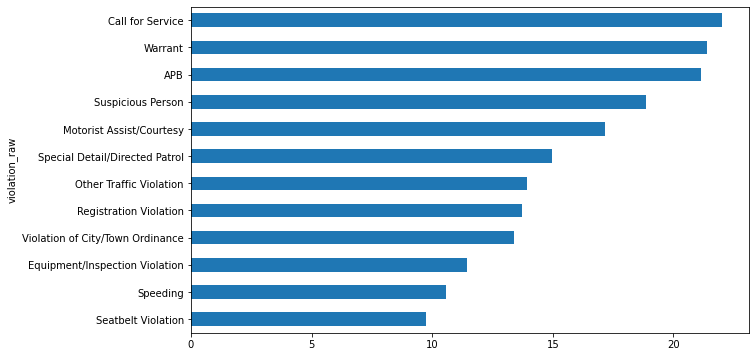

In [30]:
# Calculating the mean 'stop_minutes' for each value in 'violation_raw'
print(ri.groupby('violation_raw').stop_minutes.mean())

# Saving the resulting Series as 'stop_length'
stop_length = ri.groupby('violation_raw').stop_minutes.mean()

fig = plt.figure(figsize=(10,6))

# Sorting 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind = 'barh')
plt.show()

Warrants and APB's make sense that they would take the most time, but Call for Service is interesting.

### **How's the weather?**

Now, let's take a look at the weather and how it relates to traffic in Rhode Island.  Rhode Island is the smallest U.S. state, so one traffic center location should be indicative of the weather in the entire state.

In [31]:
weather.head(3)

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


              TMIN         TAVG         TMAX
count  4017.000000  1217.000000  4017.000000
mean     43.484441    52.493016    61.268608
std      17.020298    17.830714    18.199517
min      -5.000000     6.000000    15.000000
25%      30.000000    39.000000    47.000000
50%      44.000000    54.000000    62.000000
75%      58.000000    68.000000    77.000000
max      77.000000    86.000000   102.000000


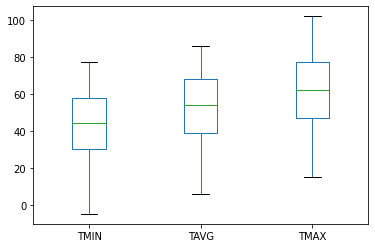

In [32]:
# Describe the temperature columns
print(weather[['TMIN', 'TAVG', 'TMAX']].describe())

# Creating box plot of the temperature columns
weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box')
plt.show()

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


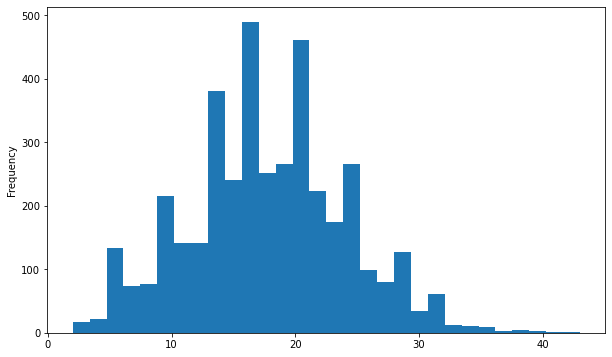

In [33]:
weather['TDIFF'] = weather.TMAX - weather.TMIN

print(weather['TDIFF'].describe())

fig = plt.figure(figsize=(10,6))
weather.TDIFF.plot(kind='hist', bins = 30)
plt.show()

Looks fairly normal and also looks like data we can use.

              AWND         WSF2
count  4017.000000  4017.000000
mean      8.593707    19.274782
std       3.364601     5.623866
min       0.220000     4.900000
25%       6.260000    15.000000
50%       8.050000    17.900000
75%      10.290000    21.900000
max      26.840000    48.100000


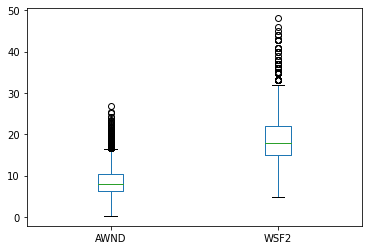

In [34]:
# Describe the wind columns
print(weather[['AWND', 'WSF2']].describe())

# Creating box plot of the wind columns
weather[['AWND', 'WSF2']].plot(kind='box')
plt.show()

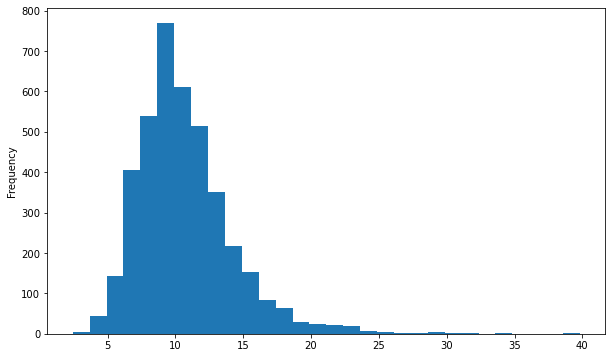

In [35]:
weather['WDIFF']= weather.WSF2 - weather.AWND

fig = plt.figure(figsize=(10,6))
weather.WDIFF.plot(kind='hist', bins = 30)
plt.show()

In [36]:
weather.shape

(4017, 29)

It looks like the weather data is a trustworthy data sample.  Now, we can prepare the data set for analysis.

In [37]:
temp = weather.loc[:, "TAVG":"TMAX"]

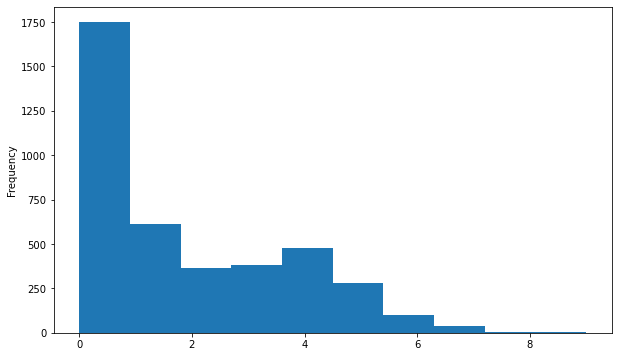

In [38]:
# Copying 'WT01' through 'WT22' to a new DataFrame
WT = weather.loc[:, 'WT01' : 'WT22']

# Calculating the sum of each row in 'WT'
weather['bad_conditions'] = WT.sum(axis = 1)

fig = plt.figure(figsize=(10,6))

# Replacing missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

weather['bad_conditions'].plot(kind = 'hist')
plt.show()

Here, we will create categories for different weather conditions - namely, good, bad and worse.

In [39]:
# Count the unique values in 'bad_conditions' and sort the index
print(weather.bad_conditions.value_counts().sort_index())

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad', 4:'bad', 5:'worse', 6:'worse', 7:'worse', 8:'worse', 9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

weather.rating.value_counts()

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64


bad      1836
good     1749
worse     432
Name: rating, dtype: int64

In [40]:
# Creating a list of weather ratings in logical order
cats = ['good', 'bad', 'worse']

# Changing the data type of 'rating' to category
weather['rating'] = pd.Categorical(weather['rating'], categories=cats, ordered=True)

Now, we will join the traffic data set with a subset of the weather data set for Rhode Island.

In [41]:
# Resetting the index of 'ri'
ri.reset_index(inplace=True)

print(ri.head())

# Creating a DataFrame from the 'DATE' and 'rating' columns
weather_rating = weather[['DATE', 'rating']]

print(weather_rating.head())

        stop_datetime   stop_date stop_time driver_gender  driver_age_raw  \
0 2005-01-02 01:55:00  2005-01-02     01:55             M          1985.0   
1 2005-01-18 08:15:00  2005-01-18     08:15             M          1965.0   
2 2005-01-23 23:15:00  2005-01-23     23:15             M          1972.0   
3 2005-02-20 17:15:00  2005-02-20     17:15             M          1986.0   
4 2005-03-14 10:00:00  2005-03-14     10:00             F          1984.0   

   driver_age driver_race     violation_raw violation  search_conducted  \
0        20.0       White          Speeding  Speeding             False   
1        40.0       White          Speeding  Speeding             False   
2        33.0       White          Speeding  Speeding             False   
3        19.0       White  Call for Service     Other             False   
4        21.0       White          Speeding  Speeding             False   

  search_type   stop_outcome  is_arrested stop_duration  drugs_related_stop  \
0      

In [42]:
print(ri.shape)

# Concatenate 'stop_date' and 'stop_time' (separated by a space)
combined = ri.stop_date.str.cat(ri.stop_time, sep = ' ')

# Convert 'combined' to datetime format
ri['stop_datetime'] = pd.to_datetime(combined)

ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')


print(ri_weather.shape)

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('stop_datetime', inplace=True)

(86113, 18)
(86113, 20)


The two columns from the weather data set were added to the traffic data set successfully.

In [43]:
ri_weather.is_arrested.mean()

0.033966996852972255

In [44]:
ri_weather.groupby('rating').is_arrested.mean()

rating
good     0.032494
bad      0.034449
worse    0.039336
Name: is_arrested, dtype: float64

In [45]:
arrest_rate = ri_weather.groupby(['violation','rating']).is_arrested.mean()

In [46]:
print(arrest_rate)

# The arrest rate for moving violations in bad weather
print(arrest_rate.loc['Moving violation', 'bad'])

# The arrest rates for speeding violations in all three weather conditions
print(arrest_rate.loc['Speeding'])

violation            rating
Equipment            good      0.051933
                     bad       0.058195
                     worse     0.098675
Moving violation     good      0.055870
                     bad       0.054201
                     worse     0.067328
Other                good      0.082857
                     bad       0.087193
                     worse     0.053312
Registration/plates  good      0.085443
                     bad       0.110086
                     worse     0.096970
Seat belt            good      0.028602
                     bad       0.019196
                     worse     0.000000
Speeding             good      0.012630
                     bad       0.013266
                     worse     0.015398
Name: is_arrested, dtype: float64
0.05420128013073676
rating
good     0.012630
bad      0.013266
worse    0.015398
Name: is_arrested, dtype: float64


It appears that there are more arrests for speeding violations when the weather is much worse than normal.  Most arrests take place when the weather is worse with exception to registration, seat belts or other which are unusual traffic stops to make an arrest.  Maybe there were warrants for arrest out or some other reason for the traffic stop.  

## **Conclusion**

Mostly all of our hypotheses about traffic stops and gender and traffic stops and weather were disproven.  It is always a good idea to take a look at your data.  Two data sets were wrangled and combined to yield that there are more arrests for speeding violations when the weather is much worse than normal. For all types of violations except for "Other", the search rate is higher for males than for females.  Additionally, the data fails to show that gender has an impact on who gets a ticket for speeding. More men were frisked and involved traffic stops where a search was conducted as the percentage for women was much lower than the average. Drug related stops are on the rise as searches being conducted is declining.